In [1]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import controller

In [2]:
ctrl = controller.controller()

In [3]:
Q = np.array(
    [
        [0,0,0,0],
        [0,900.,0,30],
        [0,0,0,0],
        [0,30,0,1]
    ]
)
R = 1.*np.eye(2) 
F = Q 

ctrl.set_cost(Q,R,F)

In [4]:
CL = 2

def f(x,u):
    return np.array([
        [(np.cos(x[2])*x[3])[0]],
        [(np.sin(x[2])*x[3])[0]],
        [((np.tan(u[1])/CL)*x[3])[0]],
        [(0.5*u[0])[0]]
    ])

def matrix_iterator(x0,u0):
    A = np.array([
        [0,    0,  (-np.sin(x0[2])*x0[3])[0],   (np.cos(x0[2]))[0]],
        [0,    0,  (np.cos(x0[2])*x0[3])[0],    (np.sin(x0[2]))[0]],
        [0,    0,  0,                      (np.tan(u0[1])/CL)[0]],
        [0,0,0,0]
    ]
    )

    B = np.array(
        [
        [0,0],
        [0,0],
        [0, (x0[3]/(np.cos(u0[1])**2 * CL))[0]],
        [0.5,0]
        ]
    )

    '''f0 = np.array([
        [(np.cos(x0[2])*x0[3])[0]],
        [(np.sin(x0[2])*x0[3])[0]],
        [((np.tan(u0[1])/CL)*x0[3])[0]],
        [(0.5*u0[0])[0]]
    ])'''
    f0 = f(x0,u0)

    return A,B,f0

x0 = np.array(
    [
        [0],
        [3.],
        [0],
        [20]
    ]
)

xd = np.array(
    [
        [0],
        [0.],
        [0],
        [20]
    ]
)

u0 = np.array(
    [
        [0],
        [0]
    ]
)


In [5]:
ctrl.pred_horizon = 20
xlist = [x0]
ulist = [u0]
ctrl.setup_model(f)
for i in range(200):
    A,B,f0 = matrix_iterator(x0,u0)
    ctrl.update_dynamics(A,x0,B,u0,f0)
    ctrl.discretize(0.1)
    x0 = ctrl.apply_control(x0,u0)
    ctrl.setup_qp_linear(x0,u0,xd)
    u = ctrl.solve_qp(x0)
    u0 = u[0:2].reshape(-1,1)
    xlist.append(x0)
    ulist.append(u0)
    #print('stepped')


In [6]:
import matplotlib.pyplot as plt

In [7]:
xm = np.array(xlist).squeeze(-1)
print(xm.shape)

(201, 4)


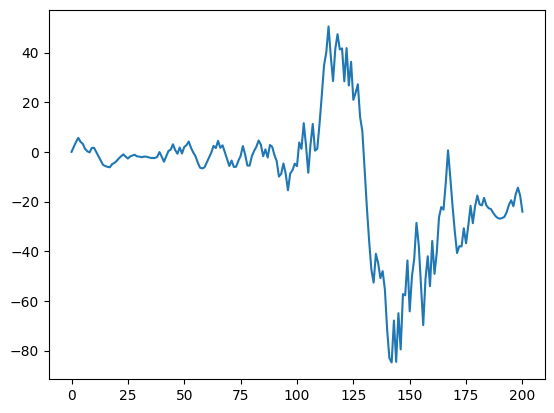

In [12]:
plt.plot(xm[:,0])

In [14]:
u_tilde = np.array(ulist).reshape(-1,2)

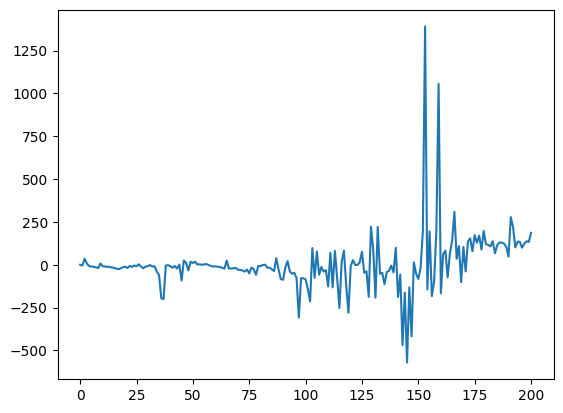

In [15]:
plt.plot(u_tilde[:,0])

In [11]:
u_tilde[6,0]

10.070179273689433